# **TP3 - Redes Neuronales**
# **Integrantes**:
Julia Sexe (65669)

Sofia Alfie (64244)

Isidro Perasso (65595)

Tobias Tardá (65730)
## Redes Neuronales Convolucionales (CNN)
#### Dataset: Dogs vs Cats

------------------------
------------------------
**Instrucciones:**

- **No** modificar las celdas de texto.

- Resolver cada consigna en su sección correspondiente. Pueden sumar celdas de código y texto si lo consideran necesario. Recuerden que lo más importante es el razonamiento y justificación de los pasos para demostrar comprensión del problema a resolver.

- **ENTREGA:** Ir a Archivo > Descargar .ipynb. Este archivo .ipynb deberán subirlo al campus junto con las diapositivas en formato PDF (archivo no editable) hasta las 23:59hs del día anterior a la presentación. La presentación oral de este último documento será de manera grupal en hasta 10 minutos  durante el horario de clase (anunciaremos el orden de los grupos en el campus).

------------------------
------------------------

# **Objetivo:** Entrenar una CNN para clasificación binaria entre gatos y perros

El dataset que usaremos fue armado para una competencia de Kaggle en 2013, donde se premiaba al mejor modelo capaz de distinguir entre fotos de gatos y perros. Los modelos ganadores alcanzaron una accuracy de ~95%.

## Carga de datos y pre-procesado

El dataset original tiene 25.000 imágenes. Acá trabajaremos con un subset de 7000 imágenes, 3500 de cada clase que los subimos a github así lo cargan facilmente.

Trabajaremos con el siguiente split:
- Train: 4000
- Validation: 1000
- Test: 2000

In [ ]:
# Clonamos el repositorio donde están las imágenes
!git clone https://github.com/juanserrano90/TP3_sia

Cloning into 'TP3_sia'...
remote: Enumerating objects: 7025, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7025 (delta 0), reused 3 (delta 0), pack-reused 7020 (from 1)
Receiving objects: 100% (7025/7025), 213.70 MiB | 51.73 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (7000/7000), done.


In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

data_root = "TP3_sia/PetImages_small"
classes = ["Cat", "Dog"]

# El dataset original tiene imágenes de distintos tamaños en formato JPG
size = (128, 128) # Vamos a redimensionar las imagenes a 128x128

X = []
y = []

for label, cls in enumerate(classes):
    folder = os.path.join(data_root, cls)
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith(".jpg")])

    for filename in files:
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, dsize = size)
        X.append(img)
        y.append(label)  # Etiqueta 0 para gatos, 1 para perros

X = np.array(X)
y = np.array(y)

# Shuffle dataset
X, y = shuffle(X, y, random_state=42)

X_train, y_train = X[:4000], y[:4000]
X_val, y_val = X[4000:5000], y[4000:5000]
X_test, y_test = X[5000:7000], y[5000:7000]

print(f"Train:\t\t {len(X_train)} images")
print(f"Validation:\t {len(X_val)} images")
print(f"Test:\t\t {len(X_test)} images")
print(f"Image shape:\t {X_train[0].shape}")

Train:		 4000 images
Validation:	 1000 images
Test:		 2000 images
Image shape:	 (128, 128, 3)


Algunas imágenes de ejemplo:

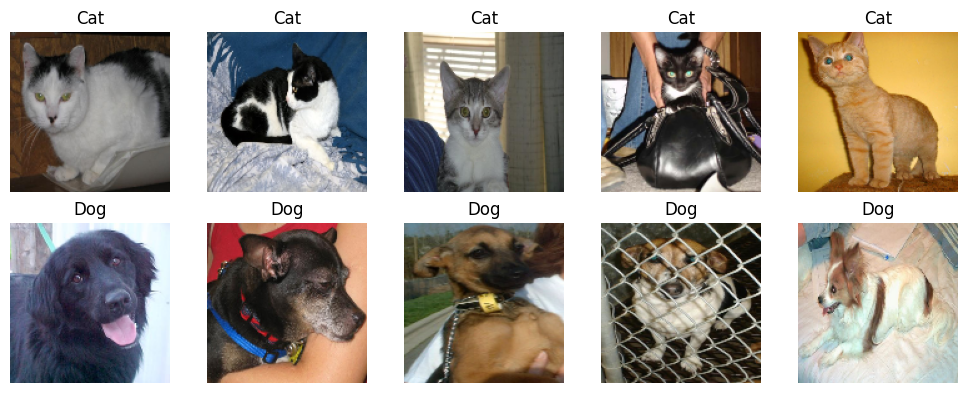

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(cv2.cvtColor(X_train[y_train==0][i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title("Cat")
    axes[0, i].axis('off')
    axes[1, i].imshow(cv2.cvtColor(X_train[y_train==1][i], cv2.COLOR_BGR2RGB))
    axes[1, i].set_title("Dog")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Lineamiento general:
Para este último TP daremos lineamientos más generales, confiamos en que ya conocen el *workflow* del aprendizaje automático. Este dataset no requiere practicamente exploración/limpieza y ya está casi listo para entrenar. Además ya les damos los splits armados. Mantengan el código simple y limpio, deberían poder hacer todo con las herramientas vistas en las notebooks de las clases.

Los requerimientos que hay que cumplir son:
*   Entrenar una CNN para clasificar las fotos de perros y gatos. Explicar claramente qué entra a la red, qué sale, cuales son las capas y qué hace cada una. Justificar la elección de las funciones de costo, activación interna y activación de salida.
*   Optimizar la red dentro de lo posible, explicando el método de optimización utilizado, espacio de búsqueda. Reportar la arquitectura final de la red y cantidad de parámetros.
*   Para el modelo final, reportar claramente los resultados en el conjunto de test.
*   Visualizar los feature maps creados por la primera capa del modelo para alguna imagen de un perro y una de un gato.

# Importación de librerías

In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
# 1. Importamos las librerías
import random
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras import layers
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("TensorFlow/Keras versión:", keras.__version__)
tf.keras.backend.clear_session()

# Comportamiento deterministico para reproducibilidad
tf.config.experimental.enable_op_determinism()

TensorFlow/Keras versión: 3.10.0


In [ ]:
# nos conectamos a Drive para poder ir guardando los resultados de las redes

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocesado

In [ ]:
# Veamos las etiquetas
print("Etiquetas:", np.unique(y_train))

Etiquetas: [0 1]


In [ ]:
# ¿Como son los datos?
print(f"Forma de los datos: {X_train[0].shape}") # las imagenes son de 128 x 128 pixeles y son de color (RBG)
print(f"Tipo de datos: {X_train[0].dtype}") # el tipo de dato es entero sin signo de 8 bits, con eso se representa cada pixel
print(f"Rango de valores: [{X_train.min()}, {X_train.max()}]") # la intensidad de los pixeles va desde 0 hasta 255
print(f"Etiquetas: {np.unique(y_train)}") # 0 es gato, 1 es perro

Forma de los datos: (128, 128, 3)
Tipo de datos: uint8
Rango de valores: [0, 255]
Etiquetas: [0 1]


In [ ]:
# Normalización: bajamos la escala, no hace falta ir hasta 255, la escala sera de 0 a 1
X_train, X_val, X_test = X_train / 255., X_val / 255., X_test / 255.

print(f"Rango de valores antes: [0, 255]")
print(f"Rango de valores después: [{X_train.min()}, {X_train.max()}]")

# como tenemos un problema de clasificacion binaria, no vamos a codificar ya que la capa de salida tendra una neurona con la funcion de activacion sigmoidea (va a ser una probabilidad). no necesitamos tener dos salidas

Rango de valores antes: [0, 255]
Rango de valores después: [0.0, 1.0]


# Construcción del modelo CNN

## Redes sin optimización

### **Red 1**

En esta red inicial, mantuvimos los mismos parámetros de la primera red que habíamos visto en la notebook "S12_Redes Neuronales - CNN" y adaptamos la forma de la capa de entrada, de salida y la función de activación de la capa de salida.

Características de la red:
- **¿Qué entra a la red?**: imágenes de 128 x 128 píxeles, 3 canales de color (RBG).
- **¿Qué sale de la red?**: una única salida que es un valor entre 0 y 1, representa la probabilidad de pertenecer a cada una de las clases (0: gato, 1: perro).
- **¿Cuáles son las capas de la red y qué hace cada una?**:
  - *Capa de entrada*: define la forma de las imágenes que entran a la red.
  - *Capas convolucionales*: extracción de features mediante aprendizaje de patrones locales. Para todas usamos padding = 'same', lo que significa que se agregan píxeles en los bordes para preservar el tamaño de entrada. El número de filtros va aumentando ya que las capas más profundas requieren más extracción de features y por cada filtro sale un feature map. El tamaño del kernel al principio es más grande para captar patrones más “globales” desde el inicio.
    - Primera capa: filters=32, kernel_size=7.
    - Segunda capa: filters=64, kernel_size=3.
    - Tercera capa: filters=128, kernel_size=3.
  - *Capas de max pooling*: para subsamplear, es decir, achicar la dimensión de los features maps. Se aplican luego de cada capa convolucional (3).
  - *Capas de dropout*: durante el entrenamiento, de manera aleatoria, apagan (ponen a cero) una proporción de neuronas en cada capa (30%).
  - *Capa de flatten*: transforma a un vector de una dimensión para ingresar a las capas densas de MLP.
  - *Capas densas*: cada neurona de estas capas está conectada a todas las neuronas de la capa anterior.
    - Primera capa: units=64 neuronas.
    - Segunda capa: units=32 neuronas.
  - *Capa de salida*: tiene una sola neurona porque es clasificación binaria.
- **¿Por qué elegimos binary_crossentropy como función de costo?**: porque tenemos un problema de clasificación binaria y esa es la función de costo estándar.
- **¿Por qué elegimos relu como función de activación interna?**: porque es eficiente e introduce la no linealidad para que el modelo pueda aprender relaciones complejas.
- **¿Por qué elegimos sigmoid como función de activación de salida?**: porque tenemos un problema de clasificación binaria y da valores entre 0 y 1, por lo que se puede interpretar como una probabilidad.

**Resultados**:
- 20 épocas
- Test Loss: 0.5457
- Mejor val_accuracy: 0.7300
- Test Accuracy: 0.7285 (72.85%)
- 2.196.417 parámetros

El resultado no es del todo bueno en esta prueba inicial, hay mucho margen de mejora.

In [ ]:
# Definimos el modelo de manera secuencial

keras.utils.set_random_seed(812)  # fijamos la random seed de tensorflow para que el resultado sea reproducible (la eleccion del numero 812 es completamente aleatoria)

model = tf.keras.Sequential([
    layers.Input(shape=[128, 128, 3]), # Capa de entrada. en esta lista vamos agregando capa por capa
# las imagenes son de 128 x 128 pixeles y hay tres canales porque es RBG
    layers.Conv2D(filters=32, kernel_size=7, padding="same",           # 1ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # filters = 32 es que por cada filter sale un feature map
    # kernel = 7 es que la matriz es de 7 x 7
    # padding = same agrega ceros en los bordes para que la dimension sea igual a la de entrada
    # kernel initizalizer = normal es un inicializador que en vez de ser aleatorio toma valores que tienen que ver con la varianza que tienen los pixeles, dentro de distribucion normal
    layers.MaxPool2D(), # por defecto es de 2 x 2. agarra matrices de 2 x 2 y se queda con el maximo
    layers.Dropout(0.3), # durante el entrenamiento, un 30 porciento de las conexiones (los pesos) se van a anular. esto es para impedir que las capas se especialicen en solo ciertas imagenes

    layers.Conv2D(filters=64, kernel_size=3, padding="same",           # 2da capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos el tamamo del filtro, con 64
    # achicamos el tamano del kernel, con 3
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=128, kernel_size=3, padding="same",          # 3ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),

    # Ahora el MLP (fully connected). La primera capa aplana la entrada.
    layers.Flatten(), # flatten convierte eso en un vector de variables. cada pixel es una variable de entrada

    # el perceptron lo hacemos con 2 capas
    layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),   # 1ra capa densa, 64 neuronas
    layers.Dropout(0.3),                                                         # Capa de Dropout para regularización. 30% de las conexiones.

    layers.Dense(units=32, activation="relu", kernel_initializer="he_normal"),   # 2da capa densa, 32 neuronas
    layers.Dropout(0.3),                                                         # Otra capa de Dropout

    layers.Dense(units=1, activation="sigmoid")                       # Capa de salida
    ])
    # es 1 unidad porque sera una neurona que produce un unico valor entre 0 y 1
    # sigmoid porque es clasificacion binaria

# 3 sucesiones de convolucion y max pooling

In [ ]:
# Arquitectura del modelo
model.summary()

# en total nos quedan 2,196,417 parametros

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,196,417 (8.38 MB)

 Trainable params: 2,196,417 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Usemos el optimizador Adam con un learning rate de 0.001
optimizador = tf.keras.optimizers.Adam(learning_rate=0.001) # usamos el optimizador adam para entrenar

model.compile(
    optimizer=optimizador,
    loss='binary_crossentropy', # usamos binary porque es clasificacion binaria
    metrics=['accuracy']
)

In [ ]:
# Early stopping con patience=10 en la loss de validación,
# y nos quedamos con los pesos del menor loss de validación (no los de la última epoca)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=10, # cuando vea que por 10 epocas seguidas la perdida en el conjunto de validacion no mejora, va a frenar el entrenamiento ahi
                                                     restore_best_weights=True) # va a quedarse con los pesos que dieron la menor perdida en el conjunto de validacion

historia = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=(X_val, y_val), # le paso los datos de validacion
    callbacks=[early_stopping_cb],
    verbose=1
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.5009 - loss: 1.5690 - val_accuracy: 0.5360 - val_loss: 0.6930
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 265s 8s/step - accuracy: 0.5367 - loss: 0.6903 - val_accuracy: 0.5900 - val_loss: 0.6753
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 303s 9s/step - accuracy: 0.6027 - loss: 0.6685 - val_accuracy: 0.6060 - val_loss: 0.6609
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 322s 9s/step - accuracy: 0.6311 - loss: 0.6506 - val_accuracy: 0.6530 - val_loss: 0.6355
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 302s 9s/step - accuracy: 0.6568 - loss: 0.6174 - val_accuracy: 0.6810 - val_loss: 0.6107
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 258s 8s/step - accuracy: 0.6919 - loss: 0.5869 - val_accuracy: 0.6840 - val_loss: 0.5955
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 254s 8s/step - accuracy: 0.6922 - loss: 0.5766 - val_accuracy: 0.7060 - val_loss: 0.5756
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 269s 8s/step - accuracy: 0.7082 - loss: 0.5552 - val_accuracy: 0.

In [ ]:
# Evaluemos en el conjunto de testeo
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test Loss: 0.5457
Test Accuracy: 0.7285 (72.85%)


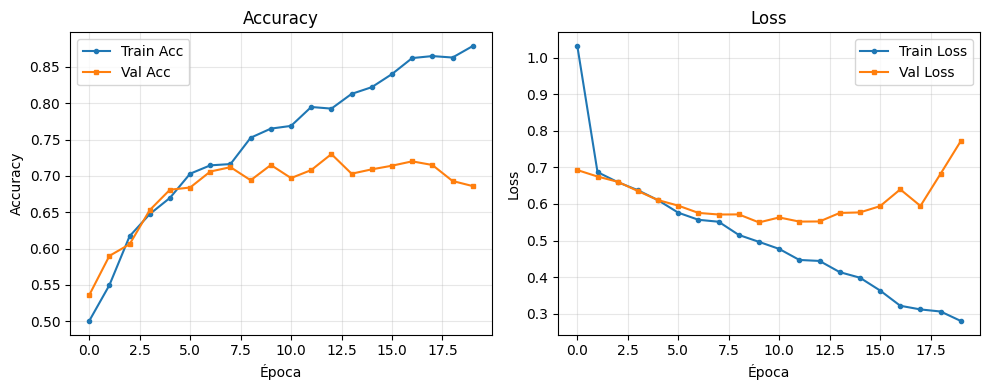

In [ ]:
# Visualizar el entrenamiento
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(historia.history['accuracy'], label='Train Acc', marker='o', ms=3)
plt.plot(historia.history['val_accuracy'], label='Val Acc', marker='s', ms=3)
plt.title('Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(historia.history['loss'], label='Train Loss', marker='o', ms=3)
plt.plot(historia.history['val_loss'], label='Val Loss', marker='s', ms=3)
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# poedemos ver que el accuracy de train se separa mucho del de validacion, signfica que estan over fitteando

### **Red 2**

En esta segunda red, utilizamos 5 capas convolucionales y de max pooling.

Las características de entrada, salida, función de costo, de activación interna y de salida se mantienen con respecto a la red anterior. También, con relación a las capas, todas son iguales salvo las de convolución y max pooling.
- *Capas convolucionales*:
  - Primera capa: filters=32, kernel_size=7.
  - Segunda capa: filters=64, kernel_size=3.
  - Tercera capa: filters=128, kernel_size=3.
  - Cuarta capa: filters=160, kernel_size=3.
  - Quinta capa: filters=256, kernel_size=3.
- *Capas de max pooling*: se aplican luego de cada capa convolucional (5).

**Resultados**:
- 45 épocas
- Test Loss: 0.4910
- Mejor val_accuracy: 0.7670
- Test Accuracy: 0.7715 (77.15%)
- 914.785 parámetros

In [ ]:
# Definimos el modelo de manera secuencial

keras.utils.set_random_seed(812)  # fijamos la random seed de tensorflow para que el resultado sea reproducible (la eleccion del numero 812 es completamente aleatoria)

model2 = tf.keras.Sequential([
    layers.Input(shape=[128, 128, 3]), # Capa de entrada. en esta lista vamos agregando capa por capa
# las imagenes son de 128 x 128 pixeles y hay tres canales porque es RBG
    layers.Conv2D(filters=32, kernel_size=7, padding="same",           # 1ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # filters = 32 es que por cada filter sale un feature map
    # kernel = 7 es que la matriz es de 7 x 7
    # padding = same agrega ceros en los bordes para que la dimension sea igual a la de entrada
    # kernel initizalizer = normal es un inicilaizador que en vez de ser aleatorio toma valores que tienen que ver con la varianza que tienen los pixeles, dentro de distribucion normal
    layers.MaxPool2D(), # por defecto es de 2 x 2. agarra matrices de 2 x 2 y se queda con el maximo
    layers.Dropout(0.3), # durante el entrenamiento, un 30 porciento de las conexiones (los pesos) se van a anular. esto es para impedir que las capas se especialicen en solo ciertas imagenes

    layers.Conv2D(filters=64, kernel_size=3, padding="same",           # 2da capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos el tamamo del filtro, con 64
    # achicamos el tamano del kernel, con 3
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=128, kernel_size=3, padding="same",          # 3ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=160, kernel_size=3, padding="same",          # 4ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=256, kernel_size=3, padding="same",          # 5ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),

    # Ahora el MLP (fully connected). La primera capa aplana la entrada.
    layers.Flatten(), # flatten convierte eso en un vector de variables. cada pixel es una variable de entrada

    # el perceptron lo hacemos con 2 capas
    layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),   # 1ra capa densa, 64 neuronas
    layers.Dropout(0.3),                                                         # Capa de Dropout para regularización. 30% de las conexiones.

    layers.Dense(units=32, activation="relu", kernel_initializer="he_normal"),   # 2da capa densa, 32 neuronas
    layers.Dropout(0.3),                                                         # Otra capa de Dropout

    layers.Dense(units=1, activation="sigmoid")                       # Capa de salida
    ])
    # es 1 unidad porque sera una neurona que produce un unico valor entre 0 y 1
    # sigmoid porque es clasificacion binaria

# 5 sucesiones de convolucion y max pooling

In [ ]:
# Arquitectura del modelo
model2.summary()

# en total nos quedan 914,785 parametros
# son menos parametros que la red anterior debido a las capas adicionales de Max Pooling que reducen la cantidad de parametros

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 160)    │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       368,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,785 (3.49 MB)

 Trainable params: 914,785 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Usemos el optimizador Adam con un learning rate de 0.001
optimizador = tf.keras.optimizers.Adam(learning_rate=0.001) # usamos el otpimizador adam para entrenar

model2.compile(
    optimizer=optimizador,
    loss='binary_crossentropy', # usamos binary porque es clasificacion binaria
    metrics=['accuracy']
)

In [ ]:
# Early stopping con patience=10 en la loss de validación,
# y nos quedamos con los pesos del menor loss de validación (no los de la última epoca)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=10, # cuando vea que por 10 epocas seguidas la perdida en el conjunto de validacion no mejora, va a frenar el entrenamiento ahi
                                                     restore_best_weights=True) # va a quedarse con los pesos que dieron la menor perdida en el conjunto de validacion

historia = model2.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=(X_val, y_val), # le paso los datos de validacion
    callbacks=[early_stopping_cb],
    verbose=1
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 298s 9s/step - accuracy: 0.4874 - loss: 1.4483 - val_accuracy: 0.5470 - val_loss: 0.6927
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 306s 9s/step - accuracy: 0.5233 - loss: 0.6916 - val_accuracy: 0.5290 - val_loss: 0.6924
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 322s 9s/step - accuracy: 0.5450 - loss: 0.6874 - val_accuracy: 0.5390 - val_loss: 0.6889
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 270s 8s/step - accuracy: 0.5767 - loss: 0.6789 - val_accuracy: 0.6120 - val_loss: 0.6691
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 268s 8s/step - accuracy: 0.5954 - loss: 0.6657 - val_accuracy: 0.5540 - val_loss: 0.6789
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.6092 - loss: 0.6596 - val_accuracy: 0.5440 - val_loss: 0.6818
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 398s 11s/step - accuracy: 0.6372 - loss: 0.6404 - val_accuracy: 0.6040 - val_loss: 0.6605
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 314s 10s/step - accuracy: 0.6459 - loss: 0.6271 - val_accuracy: 

In [ ]:
# Evaluemos en el conjunto de testeo
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test Loss: 0.4910
Test Accuracy: 0.7715 (77.15%)


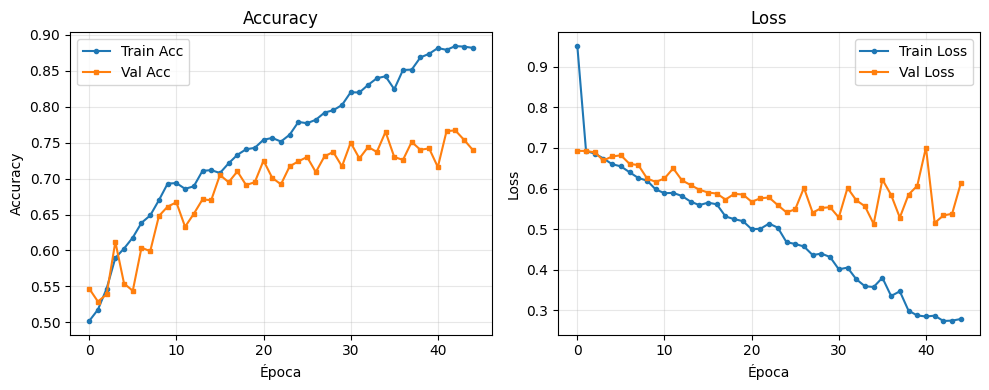

In [ ]:
# Visualizar el entrenamiento
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(historia.history['accuracy'], label='Train Acc', marker='o', ms=3)
plt.plot(historia.history['val_accuracy'], label='Val Acc', marker='s', ms=3)
plt.title('Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(historia.history['loss'], label='Train Loss', marker='o', ms=3)
plt.plot(historia.history['val_loss'], label='Val Loss', marker='s', ms=3)
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# mejoro el overfitting

### **Red 3**

En esta tercera red, utilizamos la misma arquitectura de la red 2. La única diferencia es que en el optimizador Adam usamos un learning rate = 0.0001 (antes veníamos usando 0.001).

El learning rate controla el tamaño de los pasos que toma el optimizador en cada iteración para descender por el gradiente de la función de pérdida. Un learning rate más chico significa pasos más pequeños y cautelosos, lo que puede ayudar a que el modelo converja de manera más estable y evite "saltar" el mínimo, aunque también puede hacer que el entrenamiento sea más lento.

**Resultados**:
- 200 épocas
- Test Loss: 0.4969
- Mejor val_accuracy: 0.7710
- Test Accuracy: 0.7715 (77.15%)
- 914.785 parámetros

In [ ]:
# Definimos el modelo de manera secuencial

keras.utils.set_random_seed(812)  # fijamos la random seed de tensorflow para que el resultado sea reproducible (la eleccion del numero 812 es completamente aleatoria)

modelo3 = tf.keras.Sequential([
    layers.Input(shape=[128, 128, 3]), # Capa de entrada. en esta lista vamos agregando capa por capa
# las imagenes son de 128 x 128 pixeles y hay tres canales porque es RBG
    layers.Conv2D(filters=32, kernel_size=7, padding="same",           # 1ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # filters = 32 es que por cada filter sale un feature map
    # kernel = 7 es que la matriz es de 7 x 7
    # padding = same agrega ceros en los bordes para que la dimension sea igual a la de entrada
    # kernel initizalizer = normal es un inicilaizador que en vez de ser aleatorio toma valores que tienen que ver con la varianza que tienen los pixeles, dentro de distribucion normal
    layers.MaxPool2D(), # por defecto es de 2 x 2. agarra matrices de 2 x 2 y se queda con el maximo
    layers.Dropout(0.3), # durante el entrenamiento, un 30 porciento de las conexiones (los pesos) se van a anular. esto es para impedir que las capas se especialicen en solo ciertas imagenes

    layers.Conv2D(filters=64, kernel_size=3, padding="same",           # 2da capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos el tamamo del filtro, con 64
    # achicamos el tamano del kernel, con 3
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=128, kernel_size=3, padding="same",          # 3ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=160, kernel_size=3, padding="same",          # 4ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=256, kernel_size=3, padding="same",          # 5ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),

    # Ahora el MLP (fully connected). La primera capa aplana la entrada.
    layers.Flatten(), # flatten convierte eso en un vector de variables. cada pixel es una variable de entrada

    # el perceptron lo hacemos con 2 capas
    layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),   # 1ra capa densa, 64 neuronas
    layers.Dropout(0.3),                                                         # Capa de Dropout para regularización. 30% de las conexiones.

    layers.Dense(units=32, activation="relu", kernel_initializer="he_normal"),   # 2da capa densa, 32 neuronas
    layers.Dropout(0.3),                                                         # Otra capa de Dropout

    layers.Dense(units=1, activation="sigmoid")                       # Capa de salida
    ])
    # es 1 unidad porque sera una neurona que produce un unico valor entre 0 y 1
    # sigmoid porque es clasificacion binaria

# 5 sucesiones de convolucion y max pooling

In [ ]:
# Arquitectura del modelo
modelo3.summary()

# en total nos quedan 914,785 parametros

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 160)    │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       368,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,785 (3.49 MB)

 Trainable params: 914,785 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Usemos el optimizador Adam con un learning rate de 0.0001
optimizador = tf.keras.optimizers.Adam(learning_rate=0.0001) # usamos el otpimizador adam para entrenar

modelo3.compile(
    optimizer=optimizador,
    loss='binary_crossentropy', # usamos binary porque es clasificacion binaria
    metrics=['accuracy']
)

In [ ]:
# Early stopping con patience=10 en la loss de validación,
# y nos quedamos con los pesos del menor loss de validación (no los de la última epoca)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=50, # cuando vea que por 10 epocas seguidas la perdida en el conjunto de validacion no mejora, va a frenar el entrenamiento ahi
                                                     restore_best_weights=True) # va a quedarse con los pesos que dieron la menor perdida en el conjunto de validacion

historia = modelo3.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=(X_val, y_val), # le paso los datos de validacion
    callbacks=[early_stopping_cb],
    verbose=1
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.5054 - loss: 1.4010 - val_accuracy: 0.5410 - val_loss: 0.6910
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.5114 - loss: 0.7049 - val_accuracy: 0.5400 - val_loss: 0.6928
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.5223 - loss: 0.6923 - val_accuracy: 0.5720 - val_loss: 0.6926
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.5298 - loss: 0.6907 - val_accuracy: 0.5770 - val_loss: 0.6921
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.4963 - loss: 0.6936 - val_accuracy: 0.5330 - val_loss: 0.6929
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.5210 - loss: 0.6925 - val_accuracy: 0.5290 - val_loss: 0.6929
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.5305 - loss: 0.6909 - val_accuracy: 0.5320 - val_loss: 0.6928
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.5325 - loss: 0.6911 - val_acc

In [ ]:
# Evaluemos en el conjunto de testeo
test_loss, test_accuracy = modelo3.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test Loss: 0.4969
Test Accuracy: 0.7715 (77.15%)


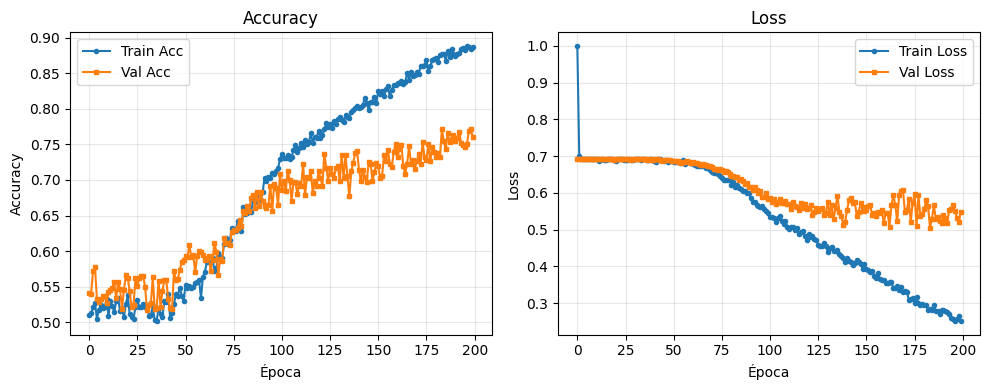

In [ ]:
# Visualizar el entrenamiento
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(historia.history['accuracy'], label='Train Acc', marker='o', ms=3)
plt.plot(historia.history['val_accuracy'], label='Val Acc', marker='s', ms=3)
plt.title('Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(historia.history['loss'], label='Train Loss', marker='o', ms=3)
plt.plot(historia.history['val_loss'], label='Val Loss', marker='s', ms=3)
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Red 4**

En esta cuarta red, utilizamos la misma arquitectura de las redes 2 y 3. La única diferencia es que en el optimizador Adam usamos un learning rate = 0.0005

Tomamos esta decisión para probar un punto intermedio y que el learning rate no sea tan chico como 0.0001.

**Resultados**:
- 90 épocas
- Test Loss: 0.4190
- Mejor val_accuracy: 0.8030
- Test Accuracy: 0.8170 (81.70%)
- 914.785 parámetros

In [ ]:
# Definimos el modelo de manera secuencial

keras.utils.set_random_seed(812)  # fijamos la random seed de tensorflow para que el resultado sea reproducible (la eleccion del numero 812 es completamente aleatoria)

modelo4 = tf.keras.Sequential([
    layers.Input(shape=[128, 128, 3]), # Capa de entrada. en esta lista vamos agregando capa por capa
# las imagenes son de 128 x 128 pixeles y hay tres canales porque es RBG
    layers.Conv2D(filters=32, kernel_size=7, padding="same",           # 1ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # filters = 32 es que por cada filter sale un feature map
    # kernel = 7 es que la matriz es de 7 x 7
    # padding = same agrega ceros en los bordes para que la dimension sea igual a la de entrada
    # kernel initizalizer = normal es un inicilaizador que en vez de ser aleatorio toma valores que tienen que ver con la varianza que tienen los pixeles, dentro de distribucion normal
    layers.MaxPool2D(), # por defecto es de 2 x 2. agarra matrices de 2 x 2 y se queda con el maximo
    layers.Dropout(0.3), # durante el entrenamiento, un 30 porciento de las conexiones (los pesos) se van a anular. esto es para impedir que las capas se especialicen en solo ciertas imagenes

    layers.Conv2D(filters=64, kernel_size=3, padding="same",           # 2da capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos el tamamo del filtro, con 64
    # achicamos el tamano del kernel, con 3
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=128, kernel_size=3, padding="same",          # 3ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=160, kernel_size=3, padding="same",          # 4ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    layers.Conv2D(filters=256, kernel_size=3, padding="same",          # 5ra capa convolucional + MaxPool2D
                           activation="relu", kernel_initializer="he_normal"),
    # aca aumentamos de nuevo al doble la cantidad de filtros
    layers.MaxPool2D(),

    # Ahora el MLP (fully connected). La primera capa aplana la entrada.
    layers.Flatten(), # flatten convierte eso en un vector de variables. cada pixel es una variable de entrada

    # el perceptron lo hacemos con 2 capas
    layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),   # 1ra capa densa, 64 neuronas
    layers.Dropout(0.3),                                                         # Capa de Dropout para regularización. 30% de las conexiones.

    layers.Dense(units=32, activation="relu", kernel_initializer="he_normal"),   # 2da capa densa, 32 neuronas
    layers.Dropout(0.3),                                                         # Otra capa de Dropout

    layers.Dense(units=1, activation="sigmoid")                       # Capa de salida
    ])
    # es 1 unidad porque sera una neurona que produce un unico valor entre 0 y 1
    # sigmoid porque es clasificacion binaria

# 5 sucesiones de convolucion y max pooling

In [ ]:
# Arquitectura del modelo
modelo4.summary()

# en total nos quedan 914,785 parametros

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 160)    │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       368,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,785 (3.49 MB)

 Trainable params: 914,785 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Usemos el optimizador Adam con un learning rate de 0.0005
optimizador = tf.keras.optimizers.Adam(learning_rate=0.0005) # usamos el otpimizador adam para entrenar

modelo4.compile(
    optimizer=optimizador,
    loss='binary_crossentropy', # usamos binary porque es clasificacion binaria
    metrics=['accuracy']
)

In [ ]:
# Early stopping con patience=10 en la loss de validación,
# y nos quedamos con los pesos del menor loss de validación (no los de la última epoca)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=35, # cuando vea que por 10 epocas seguidas la perdida en el conjunto de validacion no mejora, va a frenar el entrenamiento ahi
                                                     restore_best_weights=True) # va a quedarse con los pesos que dieron la menor perdida en el conjunto de validacion

historia = modelo4.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=(X_val, y_val), # le paso los datos de validacion
    callbacks=[early_stopping_cb],
    verbose=1
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.4820 - loss: 1.4488 - val_accuracy: 0.4780 - val_loss: 0.6934
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.5003 - loss: 0.6937 - val_accuracy: 0.4860 - val_loss: 0.6934
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.5220 - loss: 0.6920 - val_accuracy: 0.5590 - val_loss: 0.6920
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.5171 - loss: 0.6884 - val_accuracy: 0.5670 - val_loss: 0.6910
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.5349 - loss: 0.6835 - val_accuracy: 0.5520 - val_loss: 0.6894
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.5744 - loss: 0.6757 - val_accuracy: 0.5910 - val_loss: 0.6825
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.5789 - loss: 0.6725 - val_accuracy: 0.5380 - val_loss: 0.6878
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.5805 - loss: 0.6709 - val_acc

In [ ]:
# Evaluemos en el conjunto de testeo
test_loss, test_accuracy = modelo4.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test Loss: 0.4190
Test Accuracy: 0.8170 (81.70%)


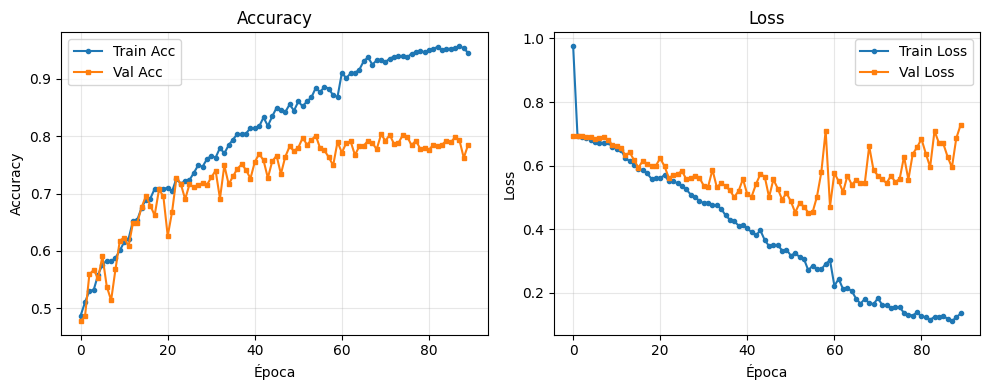

In [ ]:
# Visualizar el entrenamiento
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(historia.history['accuracy'], label='Train Acc', marker='o', ms=3)
plt.plot(historia.history['val_accuracy'], label='Val Acc', marker='s', ms=3)
plt.title('Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(historia.history['loss'], label='Train Loss', marker='o', ms=3)
plt.plot(historia.history['val_loss'], label='Val Loss', marker='s', ms=3)
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# mejoro el overfitting

## Redes con optimización

### Red Opt I

En esta red inicial optimizada, mantuvimos la misma secuencia de capas convolucionales y de max pooling que la Red 1 (3 secuencias). Luego, variamos la cantidad de capas densas.

Características de la red:
- **¿Cuál fue el método de optimización utilizado?**: utilizamos Keras Tuner con el algoritmo de Bayesian Optimization. La función objetivo es val_accuracy.
- **¿Cuál fue el espacio de búsqueda?**:
  - Filtros: en la primera, segunda y tercera capa convolucional.
  - Kernel size: en la primera capa convolucional.
  - Tasa de dropout: después de las dos primeras capas convolucionales. También, en las capas densas si se activaba o no y su tasa.
  - Cantidad de capas densas ocultas: entre 1 y 4 capas densas.
  - Cantidad de neuronas en cada capa densa.
  - Learning rate del optimizador Adam.
- **¿Cuál fue la arquitectura final de la red?**:
  - Capa de entrada.
  - Capas convolucionales:
    - Primera capa: filters=32, kernel_size=5.
    - Segunda capa: filters=32, kernel_size=3.
    - Tercera capa: filters=128 (eligió la cantidad máxima), kernel_size=3.
  - Capas de max pooling (3).
  - Capas de dropout:
    - Primera capa: tasa 0.2.
    - Segunda capa: tasa 0.4.
    - Dropout en capas densas: False (no se aplicó).
  - Capa de flatten.
  - Capas densas (eligió la cantidad máxima):
    - Primera capa: units=64 neuronas.
    - Segunda capa: units=256 neuronas.
    - Tercera capa: units=64 neuronas.
    - Cuarta capa: units=32 neuronas.
  - Capa de salida.
  - Optimizador Adam con learning_rate=0.001.
- **¿Cuál fue la cantidad de parámetros de la red final?**: el número total de parámetros para esta arquitectura final encontrada en la 'Red Opt I' es de 2,181,089 parámetros.

**Resultados**:
- Mejor val_accuracy: 0.7590 (75,90%)
- Accuracy en TEST: 0.7505 (75,05%)
- 2.181.089 parámetros

In [ ]:
# Vamos a definir la función que arma el modelo usando el espacio de parámetros que digamos

def build_model(hp):                # hp es un objeto de keras tuner (hp: hyper-parameter object)
    model = keras.Sequential([
        keras.layers.Input(shape=(128, 128, 3)),

        # con filter cambiamos el numero de lupas
        # con kernel size cambiamos el tamano de la lupa
        # aca tambien se podria cambiar el tamano de strike

        layers.Conv2D(filters=hp.Choice('filters_1', [16, 32, 64]), # para la cantidad de filtros de la primera capa le damos 3 opciones. elije entre 16, 32 y 64
                      kernel_size=hp.Choice('kernel_size_1', [3, 5, 7]), # aca lo mismo, para el tamano del kernel
                      padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=hp.Choice('dropout_1', [0.2, 0.3])),

        layers.Conv2D(filters=hp.Choice('filters_2', [32, 64, 128]),
                      kernel_size=3, padding='same',activation='relu',kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=hp.Choice('dropout_2', [0.2, 0.3, 0.4])),

        layers.Conv2D(filters=hp.Choice('filters_3', [64, 128]),
            kernel_size=3,padding='same',activation='relu',kernel_initializer='he_normal'),
        layers.MaxPooling2D()])

    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 4)): # probamos entre 1 y 4 capas
      model.add(
      layers.Dense(units=hp.Choice(f"units_{i}", [32, 64, 128, 256]),
          activation='relu',kernel_initializer='he_normal'),)

      if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Choice(f'dropout_dense_{i}', [0.3, 0.4, 0.5])))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4]) # tambien probamos distintos learning rates
        ),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
# Creamos un directorio que vaya guardando los logs de la búsqueda
# Esto es util si la busqueda tarda mucho, porque si se llega a crashear o algo
# va a continuar desde donde terminó en vez de empezar de nuevo
# Para eso tengo que pasar la address de la carpeta donde guardar los logs
# y setear el parámetro overwrite=False (igual es False por defecto)
# Ojo si trabajan con colab que los directorios que crean se eliminan al borrar el tiempo de ejecución.
# Si quieren que se guarde deberían conectar con Drive e ir guardando ahí.

!mkdir -p /content/keras-tuner-logs
path = "/content/drive/MyDrive/Colab Notebooks/SIA/TP3"

In [ ]:
tuner = kt.BayesianOptimization(build_model,# le pasamos la funcion con los posibles modelos
                                objective="val_accuracy",
                                max_trials=10, # esto define cuantos modelos distintos prueba
                                executions_per_trial=1, # esto define por cada combinacion de parametros, cuantas veces la hace
                                seed=42,
                                directory=path, # esto es para ir guardando los resultados por si se cierra todo
                                overwrite=False)

In [ ]:
# podemos visualizar el espacio de busqueda con
tuner.search_space_summary()

Search space summary
Default search space size: 10
filters_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout_1 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3], 'ordered': True}
filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_2 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}


In [ ]:
callbacks_search = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5) # le ponemos una paciencia baja para que corte rapido

tuner.search(X_train,
             y_train,
             batch_size=128,
             epochs=200,
             validation_data=(X_val, y_val),
             callbacks=[callbacks_search],
             verbose=2)

Trial 10 Complete [00h 00m 26s]
val_accuracy: 0.5249999761581421

Best val_accuracy So Far: 0.7590000033378601
Total elapsed time: 00h 15m 44s


In [ ]:
tuner.get_best_hyperparameters()[0].values

# aca podemos obtener cuales fueron los mejores valores

{'filters_1': 32,
 'kernel_size_1': 5,
 'dropout_1': 0.2,
 'filters_2': 32,
 'dropout_2': 0.4,
 'filters_3': 128,
 'num_layers': 4,
 'units_0': 64,
 'dropout': False,
 'learning_rate': 0.001,
 'units_1': 256,
 'units_2': 64,
 'units_3': 32}

{'filters_1': 32,
 'kernel_size_1': 5,
 'dropout_1': 0.2,
 'filters_2': 32,
 'dropout_2': 0.4,
 'filters_3': 128,
 'num_layers': 4,
 'units_0': 64,
 'dropout': False,
 'learning_rate': 0.001,
 'units_1': 256,
 'units_2': 64,
 'units_3': 32}

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Parámetros totales: 2181089
Accuracy en TEST: 0.7505


<Figure size 640x480 with 0 Axes>

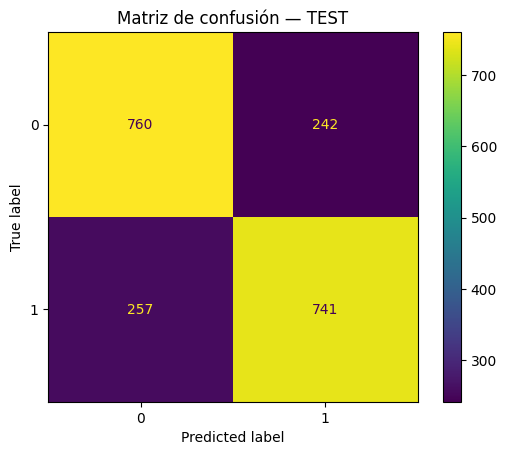

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
X = X_test
y = y_test

print("Parámetros totales:", getattr(model, "count_params", lambda: "N/A")())
y_prob = model.predict(X, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Accuracy en TEST: {acc:.4f}")

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
plt.figure()
disp.plot(values_format='d')
plt.title("Matriz de confusión — TEST")
plt.show()

### Red Opt II

En esta segunda red optimizada, mantuvimos la misma secuencia de capas convolucionales y de max pooling que las Redes 2, 3 y 4 (5 secuencias). Luego, variamos la cantidad de capas densas.

Características de la red:
- **¿Cuál fue el método de optimización utilizado?**: utilizamos Keras Tuner con el algoritmo de Bayesian Optimization. La función objetivo es val_accuracy.
- **¿Cuál fue el espacio de búsqueda?**:
  - Filtros: en las 5 capas convolucionales.
  - Kernel size: en la primera capa convolucional.
  - Tasa de dropout: después de las cuatro primeras capas convolucionales. También, en las capas densas si se activaba o no y su tasa.
  - Cantidad de capas densas ocultas: entre 3 y 6 capas densas (ampliamos el rango debido al resultado de la Red Opt I).
  - Cantidad de neuronas en cada capa densa (ampliamos el rango debido al resultado de la Red Opt I).
  - Learning rate del optimizador Adam.
- **¿Cuál fue la arquitectura final de la red?**:
  - Capa de entrada.
  - Capas convolucionales:
    - Primera capa: filters=16, kernel_size=5.
    - Segunda capa: filters=64, kernel_size=3.
    - Tercera capa: filters=64, kernel_size=3.
    - Cuarta capa: filters=128, kernel_size=3.
    - Quinta capa: filters=512, kernel_size=3.
  - Capas de max pooling (5).
  - Capas de dropout:
    - Primera capa: tasa 0.2.
    - Segunda capa: tasa 0.3.
    - Tercera capa: tasa 0.3.
    - Cuarta capa: tasa 0.4.
    - Dropout en capas densas: True (se aplicaron 4).
  - Capa de flatten.
  - Capas densas:
    - Primera capa: units=384 neuronas.
    - Segunda capa: units=64 neuronas.
    - Tercera capa: units=384 neuronas.
    - Cuarta capa: units=128 neuronas.
  - Capa de salida.
  - Optimizador Adam con learning_rate=0.001.
- **¿Cuál fue la cantidad de parámetros de la red final?**: el número total de parámetros para esta arquitectura final encontrada en la 'Red Opt II' es de 3,956,737 parámetros.

**Resultados**:
- Mejor val_accuracy: 0.7799 (77,99%)
- Accuracy en TEST: 0.7720 (77,20%)
- 3.956.737 parámetros

In [ ]:
# probamos otra opcion de modelo modificando algunos opciones para los hiperparametros
# cantidad de capas entre 3 y 6
# cantidad de neuronas agregamos los valores 384 y 512
# cantidad de filtros de las nuevas capas convolucionales 4 y 5 (y agregamos estas capas)

def build_model2(hp):                # hp es un objeto de keras tuner (hp: hyper-parameter object)
    tf.random.set_seed(42) # Set TF seed for determinism within each trial (le agregamos esto porque le faltaba una semilla y daba error)
    model = keras.Sequential([
        keras.layers.Input(shape=(128, 128, 3)),

        # con filter cambiamos el numero de lupas
        # con kernel size cambiamos el tamano de la lupa
        # aca tambien se podria cambiar el tamano de strike

        layers.Conv2D(filters=hp.Choice('filters_1', [16, 32, 64]), # para la cantidad de filtros de la primera capa le damos 3 opciones. elije entre 16, 32 y 64
                      kernel_size=hp.Choice('kernel_size_1', [3, 5, 7]), # aca lo mismo, para el tamano del kernel
                      padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=hp.Choice('dropout_1', [0.2, 0.3])),

        layers.Conv2D(filters=hp.Choice('filters_2', [32, 64, 128]),
                      kernel_size=3, padding='same',activation='relu',kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=hp.Choice('dropout_2', [0.2, 0.3, 0.4])),

        layers.Conv2D(filters=hp.Choice('filters_3', [64, 128]),
            kernel_size=3,padding='same',activation='relu',kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=hp.Choice('dropout_3', [0.2, 0.3, 0.4])),

        layers.Conv2D(filters=hp.Choice('filters_4', [128, 160, 256]), kernel_size=3, padding="same",          # 4ra capa convolucional + MaxPool2D
                              activation="relu", kernel_initializer="he_normal"),
        # aca aumentamos de nuevo al doble la cantidad de filtros
        layers.MaxPool2D(),
        layers.Dropout(rate=hp.Choice('dropout_4', [0.2, 0.3, 0.4])),

        layers.Conv2D(filters=hp.Choice('filters_5', [192, 256, 512]), kernel_size=3, padding="same",          # 5ra capa convolucional + MaxPool2D
                              activation="relu", kernel_initializer="he_normal"),
        # aca aumentamos de nuevo al doble la cantidad de filtros
        layers.MaxPool2D()])

    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 3, 6)): # probamos entre 3 y 6 capas
      model.add(
      layers.Dense(units=hp.Choice(f"units_{i}", [32, 64, 128, 256, 384, 512]),
          activation='relu',kernel_initializer='he_normal'),)

      if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Choice(f'dropout_dense_{i}', [0.3, 0.4, 0.5])))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4]) # tambien probamos distintos learning rates
        ),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
# Creamos un directorio que vaya guardando los logs de la búsqueda
# Esto es util si la busqueda tarda mucho, porque si se llega a crashear o algo
# va a continuar desde donde terminó en vez de empezar de nuevo
# Para eso tengo que pasar la address de la carpeta donde guardar los logs
# y setear el parámetro overwrite=False (igual es False por defecto)
# Ojo si trabajan con colab que los directorios que crean se eliminan al borrar el tiempo de ejecución.
# Si quieren que se guarde deberían conectar con Drive e ir guardando ahí.

!mkdir -p /content/keras-tuner-logs
path = "/content/drive/MyDrive/Colab Notebooks/SIA/TP3/Resultados segundo modelo optimizado"

In [ ]:
tuner = kt.BayesianOptimization(build_model2,# le pasamos la funcion con los posibles modelos
                                objective="val_accuracy",
                                max_trials=10, # esto define cuantos modelos distintos prueba
                                executions_per_trial=1, # esto define por cada combinacion de parametros, cuantas veces la hace
                                seed=42,
                                directory=path, # esto es para ir guardando los resultados por si se cierra todo
                                overwrite=False)

In [ ]:
# podemos visualizar el espacio de busqueda con
tuner.search_space_summary()

Search space summary
Default search space size: 16
filters_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout_1 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3], 'ordered': True}
filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_2 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dropout_3 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
filters_4 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 160, 256], 'ordered': True}
dropout_4 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
filters_5 (Choice)
{'default': 192, 'conditions': [], 'values': [192, 256, 512], 'ordered'

In [ ]:
callbacks_search = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15) # le ponemos una paciencia baja para que corte rapido

tuner.search(X_train,
             y_train,
             batch_size=128,
             epochs=200,
             validation_data=(X_val, y_val),
             callbacks=[callbacks_search],
             verbose=2)

Trial 10 Complete [00h 02m 43s]
val_accuracy: 0.5170000195503235

Best val_accuracy So Far: 0.7799999713897705
Total elapsed time: 00h 28m 31s


In [ ]:
tuner.get_best_hyperparameters()[0].values

# aca podemos obtener cuales fueron los mejores valores
# como elige 4 capas densas, los valores que eligio fueron units 0, 1, 2 y 3
# y de dropout eligio 0, 1, 2 y 3

{'filters_1': 16,
 'kernel_size_1': 5,
 'dropout_1': 0.2,
 'filters_2': 64,
 'dropout_2': 0.3,
 'filters_3': 64,
 'dropout_3': 0.3,
 'filters_4': 128,
 'dropout_4': 0.4,
 'filters_5': 512,
 'num_layers': 4,
 'units_0': 384,
 'dropout': True,
 'units_1': 64,
 'units_2': 384,
 'learning_rate': 0.001,
 'dropout_dense_0': 0.3,
 'dropout_dense_1': 0.5,
 'dropout_dense_2': 0.4,
 'units_3': 128,
 'dropout_dense_3': 0.5,
 'units_4': 256,
 'dropout_dense_4': 0.5,
 'units_5': 512,
 'dropout_dense_5': 0.3}

{'filters_1': 16,
 'kernel_size_1': 5,
 'dropout_1': 0.2,
 'filters_2': 64,
 'dropout_2': 0.3,
 'filters_3': 64,
 'dropout_3': 0.3,
 'filters_4': 128,
 'dropout_4': 0.4,
 'filters_5': 512,
 'num_layers': 4,
 'units_0': 384,
 'dropout': True,
 'units_1': 64,
 'units_2': 384,
 'learning_rate': 0.001,
 'dropout_dense_0': 0.3,
 'dropout_dense_1': 0.5,
 'dropout_dense_2': 0.4,
 'units_3': 128,
 'dropout_dense_3': 0.5,
 'units_4': 256,
 'dropout_dense_4': 0.5,
 'units_5': 512,
 'dropout_dense_5': 0.3}

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Parámetros totales: 3956737
Accuracy en TEST: 0.7720


<Figure size 640x480 with 0 Axes>

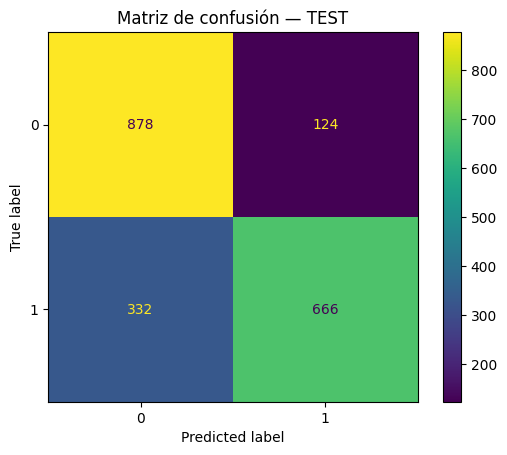

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
X = X_test
y = y_test

print("Parámetros totales:", getattr(model, "count_params", lambda: "N/A")())
y_prob = model.predict(X, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Accuracy en TEST: {acc:.4f}")

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
plt.figure()
disp.plot(values_format='d')
plt.title("Matriz de confusión — TEST")
plt.show()

### Red Opt III

En esta tercera red optimizada, mantuvimos la misma secuencia de capas convolucionales y de max pooling que las Redes 2, 3 y 4 (5 secuencias) y el learning rate de 0.0005 como en la Red 4. Luego, variamos la cantidad de capas densas.

La red mantuvo el mismo método de optimización y espacio de búsqueda que la Red Opt II, a excepción de:
- Tasa de dropout: en las capas convolucionales se mantuvieron fijas en 0.3.
- Learning rate del optimizador Adam se mantuvo fijo en 0.0005.

Además, aumentamos la cantidad de trials de 10 a 20 y la paciencia de 15 a 20 con respecto a la búsqueda anterior.
- **¿Cuál fue la arquitectura final de la red?**:
  - Capa de entrada.
  - Capas convolucionales:
    - Primera capa: filters=32, kernel_size=5.
    - Segunda capa: filters=32, kernel_size=3.
    - Tercera capa: filters=128, kernel_size=3.
    - Cuarta capa: filters=160, kernel_size=3.
    - Quinta capa: filters=192, kernel_size=3.
  - Capas de max pooling (5).
  - Capas de dropout en capas densas: False (no se aplicaron).
  - Capa de flatten.
  - Capas densas:
    - Primera capa: units=32 neuronas.
    - Segunda capa: units=384 neuronas.
    - Tercera capa: units=256 neuronas.
  - Capa de salida.
  - Optimizador Adam con learning_rate=0.0005.
- **¿Cuál fue la cantidad de parámetros de la red final?**: el número total de parámetros para esta arquitectura final encontrada en la 'Red Opt III' es de 719,649 parámetros.

**Resultados**:
- Mejor val_accuracy: 0.7990 (79,90%)
- Accuracy en TEST: 0.7840 (78,40%)
- 719.649 parámetros

In [ ]:
# probamos otra opcion de modelo modificando algunos opciones para los hiperparametros
# cantidad de capas entre 3 y 6
# cantidad de neuronas agregamos los valores 384 y 512
# cantidad de filtros de las nuevas capas convolucionales 4 y 5 (y agregamos estas capas)

def build_model3(hp):                # hp es un objeto de keras tuner (hp: hyper-parameter object)
    keras.utils.set_random_seed(812)  # fijamos la random seed de tensorflow para que el resultado sea reproducible (la eleccion del numero 812 es completamente aleatoria)

    model = keras.Sequential([
        keras.layers.Input(shape=(128, 128, 3)),

        # con filter cambiamos el numero de lupas
        # con kernel size cambiamos el tamano de la lupa
        # aca tambien se podria cambiar el tamano de strike

        layers.Conv2D(filters=hp.Choice('filters_1', [16, 32, 64]), # para la cantidad de filtros de la primera capa le damos 3 opciones. elije entre 16, 32 y 64
                      kernel_size=hp.Choice('kernel_size_1', [3, 5, 7]), # aca lo mismo, para el tamano del kernel
                      padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=hp.Choice('filters_2', [32, 64, 128]),
                      kernel_size=3, padding='same',activation='relu',kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=hp.Choice('filters_3', [64, 128]),
            kernel_size=3,padding='same',activation='relu',kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=hp.Choice('filters_4', [128, 160, 256]), kernel_size=3, padding="same",          # 4ra capa convolucional + MaxPool2D
                              activation="relu", kernel_initializer="he_normal"),
        # aca aumentamos de nuevo al doble la cantidad de filtros
        layers.MaxPool2D(),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=hp.Choice('filters_5', [192, 256, 512]), kernel_size=3, padding="same",          # 5ra capa convolucional + MaxPool2D
                              activation="relu", kernel_initializer="he_normal"),
        # aca aumentamos de nuevo al doble la cantidad de filtros
        layers.MaxPool2D()])

    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 3, 6)): # probamos entre 3 y 6 capas
      model.add(
      layers.Dense(units=hp.Choice(f"units_{i}", [32, 64, 128, 256, 384, 512]),
          activation='relu',kernel_initializer='he_normal'),)

      if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Choice(f'dropout_dense_{i}', [0.3, 0.4, 0.5])))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
# Creamos un directorio que vaya guardando los logs de la búsqueda
# Esto es util si la busqueda tarda mucho, porque si se llega a crashear o algo
# va a continuar desde donde terminó en vez de empezar de nuevo
# Para eso tengo que pasar la address de la carpeta donde guardar los logs
# y setear el parámetro overwrite=False (igual es False por defecto)
# Ojo si trabajan con colab que los directorios que crean se eliminan al borrar el tiempo de ejecución.
# Si quieren que se guarde deberían conectar con Drive e ir guardando ahí.

!mkdir -p /content/keras-tuner-logs
path = "/content/drive/MyDrive/Colab Notebooks/SIA/TP3/Resultados tercer modelo optimizado"

En esta búsqueda de optimización aumentamos la cantidad de trials (de 10 en las dos anteriores a 20).

In [ ]:
tuner = kt.BayesianOptimization(build_model3,# le pasamos la funcion con los posibles modelos
                                objective="val_accuracy",
                                max_trials=20, # esto define cuantos modelos distintos prueba
                                executions_per_trial=1, # esto define por cada combinacion de parametros, cuantas veces la hace
                                seed=812,
                                directory=path, # esto es para ir guardando los resultados por si se cierra todo
                                overwrite=False)

In [ ]:
# podemos visualizar el espacio de busqueda con
tuner.search_space_summary()

Search space summary
Default search space size: 11
filters_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
filters_4 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 160, 256], 'ordered': True}
filters_5 (Choice)
{'default': 192, 'conditions': [], 'values': [192, 256, 512], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 384, 512], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}
units_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 384, 512], 'ordere

En esta búsqueda de optimización aumentamos el valor de la paciencia (de 15 en la anterior a 20).

In [ ]:
callbacks_search = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20) # le ponemos una paciencia baja para que corte rapido

tuner.search(X_train,
             y_train,
             batch_size=128,
             epochs=200,
             validation_data=(X_val, y_val),
             callbacks=[callbacks_search],
             verbose=2)

Trial 20 Complete [00h 03m 04s]
val_accuracy: 0.4830000102519989

Best val_accuracy So Far: 0.7990000247955322
Total elapsed time: 01h 31m 44s


In [ ]:
tuner.get_best_hyperparameters()[0].values

# aca podemos obtener cuales fueron los mejores valores

{'filters_1': 32,
 'kernel_size_1': 5,
 'filters_2': 32,
 'filters_3': 128,
 'filters_4': 160,
 'filters_5': 192,
 'num_layers': 3,
 'units_0': 32,
 'dropout': False,
 'units_1': 384,
 'units_2': 256,
 'units_3': 64}

{'filters_1': 32,
 'kernel_size_1': 5,
 'filters_2': 32,
 'filters_3': 128,
 'filters_4': 160,
 'filters_5': 192,
 'num_layers': 3,
 'units_0': 32,
 'dropout': False,
 'units_1': 384,
 'units_2': 256,
 'units_3': 64}

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Parámetros totales: 719649
Accuracy en TEST: 0.7840


<Figure size 640x480 with 0 Axes>

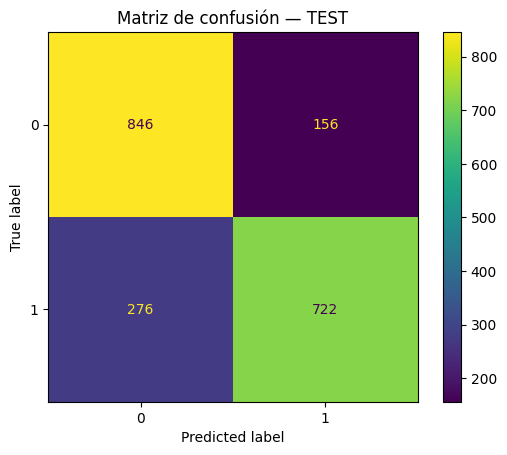

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
X = X_test
y = y_test

print("Parámetros totales:", getattr(model, "count_params", lambda: "N/A")())
y_prob = model.predict(X, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Accuracy en TEST: {acc:.4f}")

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
plt.figure()
disp.plot(values_format='d')
plt.title("Matriz de confusión — TEST")
plt.show()

### Red Opt IV

En esta cuarta red optimizada, utilizamos el mismo método de optimización y espacio de búsqueda que la Red Opt III (es decir, la función 'build_model3').

Mantuvimos la misma cantidad de trials en 20 pero aumentamos la paciencia a 35 (esta es la misma paciencia que habíamos utilizado en la Red 4).
- **¿Cuál fue la arquitectura final de la red?**:
  - Capa de entrada.
  - Capas convolucionales:
    - Primera capa: filters=64, kernel_size=5.
    - Segunda capa: filters=128, kernel_size=3.
    - Tercera capa: filters=64, kernel_size=3.
    - Cuarta capa: filters=256, kernel_size=3.
    - Quinta capa: filters=256, kernel_size=3.
  - Capas de max pooling (5).
  - Capas de dropout en capas densas: True (se aplicaron).
  - Capa de flatten.
  - Capas densas:
    - Primera capa: units=256 neuronas.
    - Segunda capa: units=64 neuronas.
    - Tercera capa: units=64 neuronas.
    - Cuarta capa: units=512 neuronas.
    - Quinta capa: units=384 neuronas.
    - Sexta capa: units=32 neuronas.
  - Capa de salida.
  - Optimizador Adam con learning_rate=0.0005.

- **¿Cuál fue la cantidad de parámetros de la red final?**: el número total de parámetros para esta arquitectura final encontrada en la 'Red Opt IV' es de 2,202,369 parámetros.

**Resultados**:
- Mejor val_accuracy: 0.8100 (81,00%)
- Accuracy en TEST: 0.8015 (80.15%)
- 2.202.369 parámetros

In [ ]:
# Creamos un directorio que vaya guardando los logs de la búsqueda
# Esto es util si la busqueda tarda mucho, porque si se llega a crashear o algo
# va a continuar desde donde terminó en vez de empezar de nuevo
# Para eso tengo que pasar la address de la carpeta donde guardar los logs
# y setear el parámetro overwrite=False (igual es False por defecto)
# Ojo si trabajan con colab que los directorios que crean se eliminan al borrar el tiempo de ejecución.
# Si quieren que se guarde deberían conectar con Drive e ir guardando ahí.

!mkdir -p /content/keras-tuner-logs
path = "/content/drive/MyDrive/Colab Notebooks/SIA/TP3/Prueba red III de nuevo"

In [ ]:
tuner = kt.BayesianOptimization(build_model3,# le pasamos la funcion con los posibles modelos
                                objective="val_accuracy",
                                max_trials=20, # esto define cuantos modelos distintos prueba
                                executions_per_trial=1, # esto define por cada combinacion de parametros, cuantas veces la hace
                                seed=812,
                                directory=path, # esto es para ir guardando los resultados por si se cierra todo
                                overwrite=False)

In [ ]:
# podemos visualizar el espacio de busqueda con
tuner.search_space_summary()

Search space summary
Default search space size: 11
filters_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
filters_4 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 160, 256], 'ordered': True}
filters_5 (Choice)
{'default': 192, 'conditions': [], 'values': [192, 256, 512], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 384, 512], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}
units_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 384, 512], 'ordere

Acá está lo que cambiamos respecto a Red Opt II: patience = 35 en vez de 20

In [ ]:
callbacks_search = keras.callbacks.EarlyStopping(monitor="val_loss", patience=35)

tuner.search(X_train,
             y_train,
             batch_size=128,
             epochs=200,
             validation_data=(X_val, y_val),
             callbacks=[callbacks_search],
             verbose=2)

Trial 20 Complete [00h 06m 13s]
val_accuracy: 0.4830000102519989

Best val_accuracy So Far: 0.8100000023841858
Total elapsed time: 02h 13m 31s


In [ ]:
tuner.get_best_hyperparameters()[0].values

# aca podemos obtener cuales fueron los mejores valores

{'filters_1': 64,
 'kernel_size_1': 5,
 'filters_2': 128,
 'filters_3': 64,
 'filters_4': 256,
 'filters_5': 256,
 'num_layers': 6,
 'units_0': 256,
 'dropout': True,
 'units_1': 64,
 'units_2': 64,
 'units_3': 512,
 'dropout_dense_0': 0.5,
 'dropout_dense_1': 0.4,
 'dropout_dense_2': 0.4,
 'dropout_dense_3': 0.4,
 'units_4': 384,
 'dropout_dense_4': 0.3,
 'units_5': 32,
 'dropout_dense_5': 0.3}

{'filters_1': 64,
 'kernel_size_1': 5,
 'filters_2': 128,
 'filters_3': 64,
 'filters_4': 256,
 'filters_5': 256,
 'num_layers': 6,
 'units_0': 256,
 'dropout': True,
 'units_1': 64,
 'units_2': 64,
 'units_3': 512,
 'dropout_dense_0': 0.5,
 'dropout_dense_1': 0.4,
 'dropout_dense_2': 0.4,
 'dropout_dense_3': 0.4,
 'units_4': 384,
 'dropout_dense_4': 0.3,
 'units_5': 32,
 'dropout_dense_5': 0.3}

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Parámetros totales: 2202369
Accuracy en TEST: 0.8015


<Figure size 640x480 with 0 Axes>

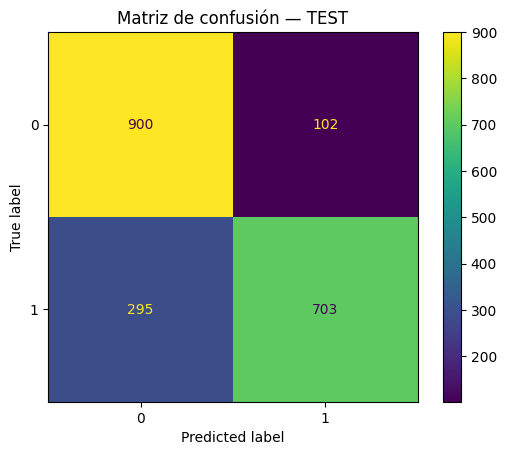

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
X = X_test
y = y_test

print("Parámetros totales:", getattr(model, "count_params", lambda: "N/A")())
y_prob = model.predict(X, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Accuracy en TEST: {acc:.4f}")

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
plt.figure()
disp.plot(values_format='d')
plt.title("Matriz de confusión — TEST")
plt.show()

# Obtenemos el mejor modelo

In [ ]:
# Mejores hiperparametros
best_hp = {'filters_1': 64,
 'kernel_size_1': 5,
 'filters_2': 128,
 'filters_3': 64,
 'filters_4': 256,
 'filters_5': 256,
 'num_layers': 6,
 'units_0': 256,
 'dropout': True,
 'units_1': 64,
 'units_2': 64,
 'units_3': 512,
 'dropout_dense_0': 0.5,
 'dropout_dense_1': 0.4,
 'dropout_dense_2': 0.4,
 'dropout_dense_3': 0.4,
 'units_4': 384,
 'dropout_dense_4': 0.3,
 'units_5': 32,
 'dropout_dense_5': 0.3}

In [ ]:
def build_model_from_dict(hp_dict):                # hp es un objeto de keras tuner (hp: hyper-parameter object)
    keras.utils.set_random_seed(812)  # fijamos la random seed de tensorflow para que el resultado sea reproducible (la eleccion del numero 812 es completamente aleatoria)

    model = keras.Sequential([
        keras.layers.Input(shape=(128, 128, 3)),

        layers.Conv2D(filters=hp_dict['filters_1'],kernel_size=hp_dict['kernel_size_1'],padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=hp_dict['filters_2'],kernel_size=3, padding='same',activation='relu',kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=hp_dict['filters_3'],kernel_size=3,padding='same',activation='relu',kernel_initializer='he_normal'),
        layers.MaxPooling2D(),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=hp_dict['filters_4'], kernel_size=3, padding="same",activation="relu", kernel_initializer="he_normal"),
        layers.MaxPool2D(),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=hp_dict['filters_5'], kernel_size=3, padding="same",activation="relu", kernel_initializer="he_normal"),
        layers.MaxPool2D()])

    model.add(layers.Flatten())

    for i in range(hp_dict["num_layers"]): # probamos entre 3 y 6 capas
      model.add(
      layers.Dense(units=hp_dict[f"units_{i}"],activation='relu',kernel_initializer='he_normal'),)
      if hp_dict.get('dropout', False):
            drop_rate = hp_dict.get(f'dropout_dense_{i}', None)
            if drop_rate is not None:
                model.add(layers.Dropout(drop_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
modelo_reconstruido = build_model_from_dict(best_hp)
modelo_reconstruido.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 384)            │             

 Total params: 2,202,369 (8.40 MB)

 Trainable params: 2,202,369 (8.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ruta_pesos = '/content/checkpoint.weights.h5'

In [ ]:
modelo_reconstruido.load_weights(ruta_pesos)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluemos nuevamente en el conjunto de testeo
test_loss, test_accuracy = modelo_reconstruido.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test Loss: 0.5551
Test Accuracy: 0.8015 (80.15%)


Parámetros totales: 2202369
Accuracy en TEST: 0.8015


<Figure size 640x480 with 0 Axes>

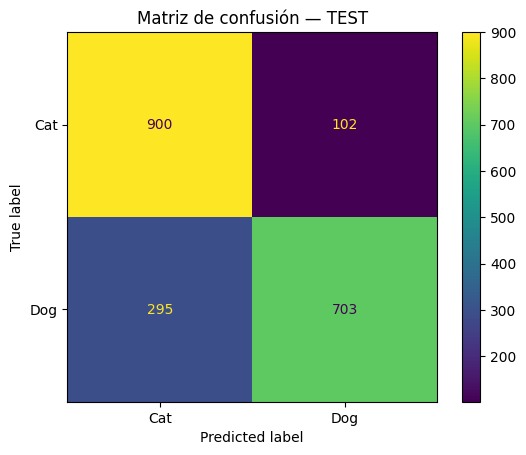

              precision    recall  f1-score   support

         Cat       0.75      0.90      0.82      1002
         Dog       0.87      0.70      0.78       998

    accuracy                           0.80      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.80      0.80      2000



In [ ]:
from sklearn.metrics import classification_report

print("Parámetros totales:", getattr(modelo_reconstruido, "count_params", lambda: "N/A")())
y_prob = modelo_reconstruido.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
acc = (y_pred == y_test).mean()
print(f"Accuracy en TEST: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes) # Use the 'classes' variable here
plt.figure()
disp.plot(values_format='d')
plt.title("Matriz de confusión — TEST")
plt.show()

print(classification_report(y_test, y_pred, target_names=classes))

Vemos entonces que le cuesta mas predecir a los perros, pero cuando predice perro es eficaz. Aunque hay muchas equivocaciones, el 80% de los casos son predichos correctamente

Ahora predecimos dos imagenes nuestras. Una de un gato y otra de un perro, para ver como las predice.

In [ ]:
fotos = pd.Series(['/content/IMG_3205.jpeg', '/content/IMG_4383.jpg', '/content/IMG_6696.jpeg', '/content/IMG_6991.jpeg','/content/IMG_0837.jpg'])
etiquetas = pd.Series([0,1,0,0,1])

df = pd.DataFrame({'path': fotos, 'label': etiquetas})

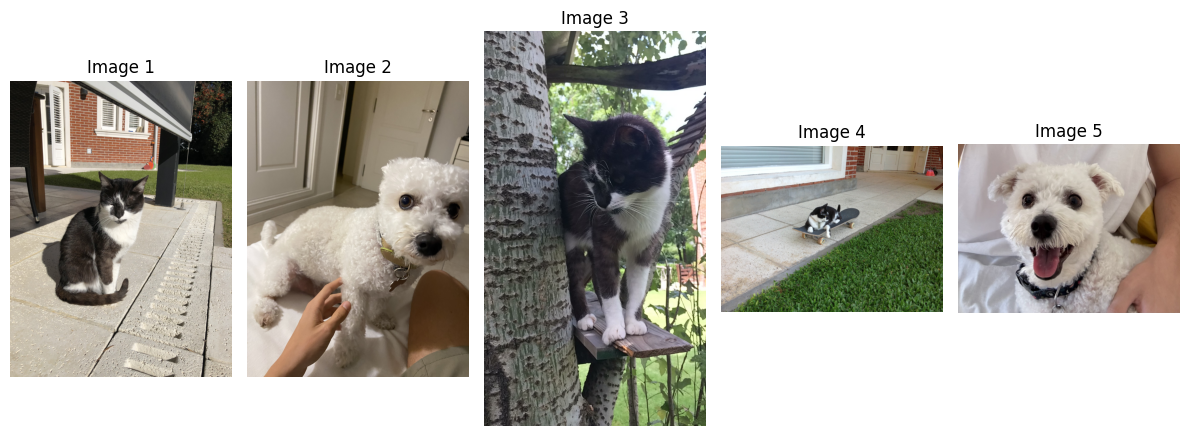

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 6)) # This creates 4 subplots in a single column
for i in range(len(fotos)):
    img = cv2.imread(fotos[i]) # Read each image file
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for displaying with matplotlib
    axes[i].imshow(img) # Access axes using a single index
    axes[i].set_title(f"Image {i+1}") # Set title for each image
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
img.shape

(1505, 1975, 3)

In [ ]:
size = (128,128)
entradas = []
etiquetas = []

for filename in df['path']:
    img = cv2.imread(filename)
    if img is None:
        continue
    img = cv2.resize(img, dsize = size)
    entradas.append(img)
    etiquetas.append(df[df['path'] == filename]['label'].values[0])

entradas = np.array(entradas)
etiquetas = np.array(etiquetas)

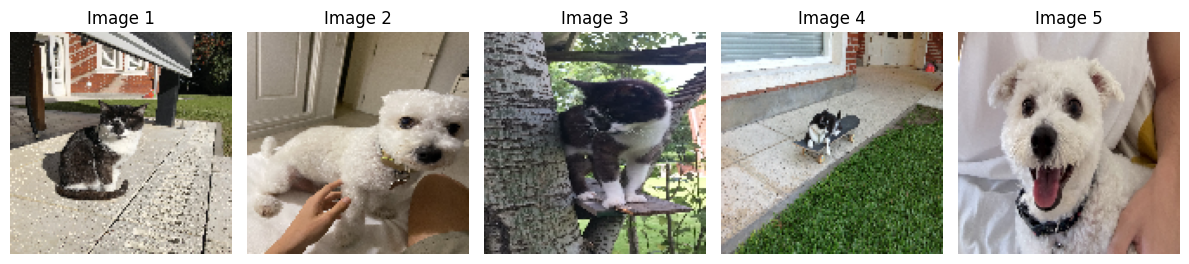

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 6))
for i in range(len(entradas)):
    axes[i].imshow(cv2.cvtColor(entradas[i], cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Comprobamos que ahora las fotos tengan el tamaño adecuado

In [ ]:
entradas[0].shape

(128, 128, 3)

Hacemos el preprocesado

In [ ]:
entradas = entradas/255.

Probamos predecir esas imagenes

In [ ]:
etiquetas

array([0, 1, 0, 0, 1])

In [ ]:
# Evaluamos con evaluate
modelo_reconstruido.evaluate(entradas, etiquetas)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6000 - loss: 0.8393


[0.8393131494522095, 0.6000000238418579]

In [ ]:
# Ahora vemos para cada foto qué predijo
y_prob = modelo_reconstruido.predict(entradas, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
acc = (y_pred == etiquetas).mean()
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.6000


In [ ]:
y_prob

array([0.35504004, 0.12580062, 0.19509245, 0.760127  , 0.96053183],
      dtype=float32)

In [ ]:
y_pred

array([0, 0, 0, 1, 1])

# Feature maps de imagenes

In [ ]:
from keras import Input, Model

# 1) batch
img = entradas[-1]
img_batch = img[None, ...].astype('float32')

# 2) crear un nuevo tensor de entrada y aplicar las primeras N capas del modelo
input_tensor = Input(shape=(128,128,3))
x = input_tensor

# por ejemplo, queremos la salida de la primera capa conv (índice 0)
for layer in modelo_reconstruido.layers[:1]:   # cambia :1 por :k para las primeras k capas
    x = layer(x)

activation_model = Model(inputs=input_tensor, outputs=x)

# 3) predecir
feature_maps = activation_model.predict(img_batch)
print(feature_maps.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
(1, 128, 128, 64)


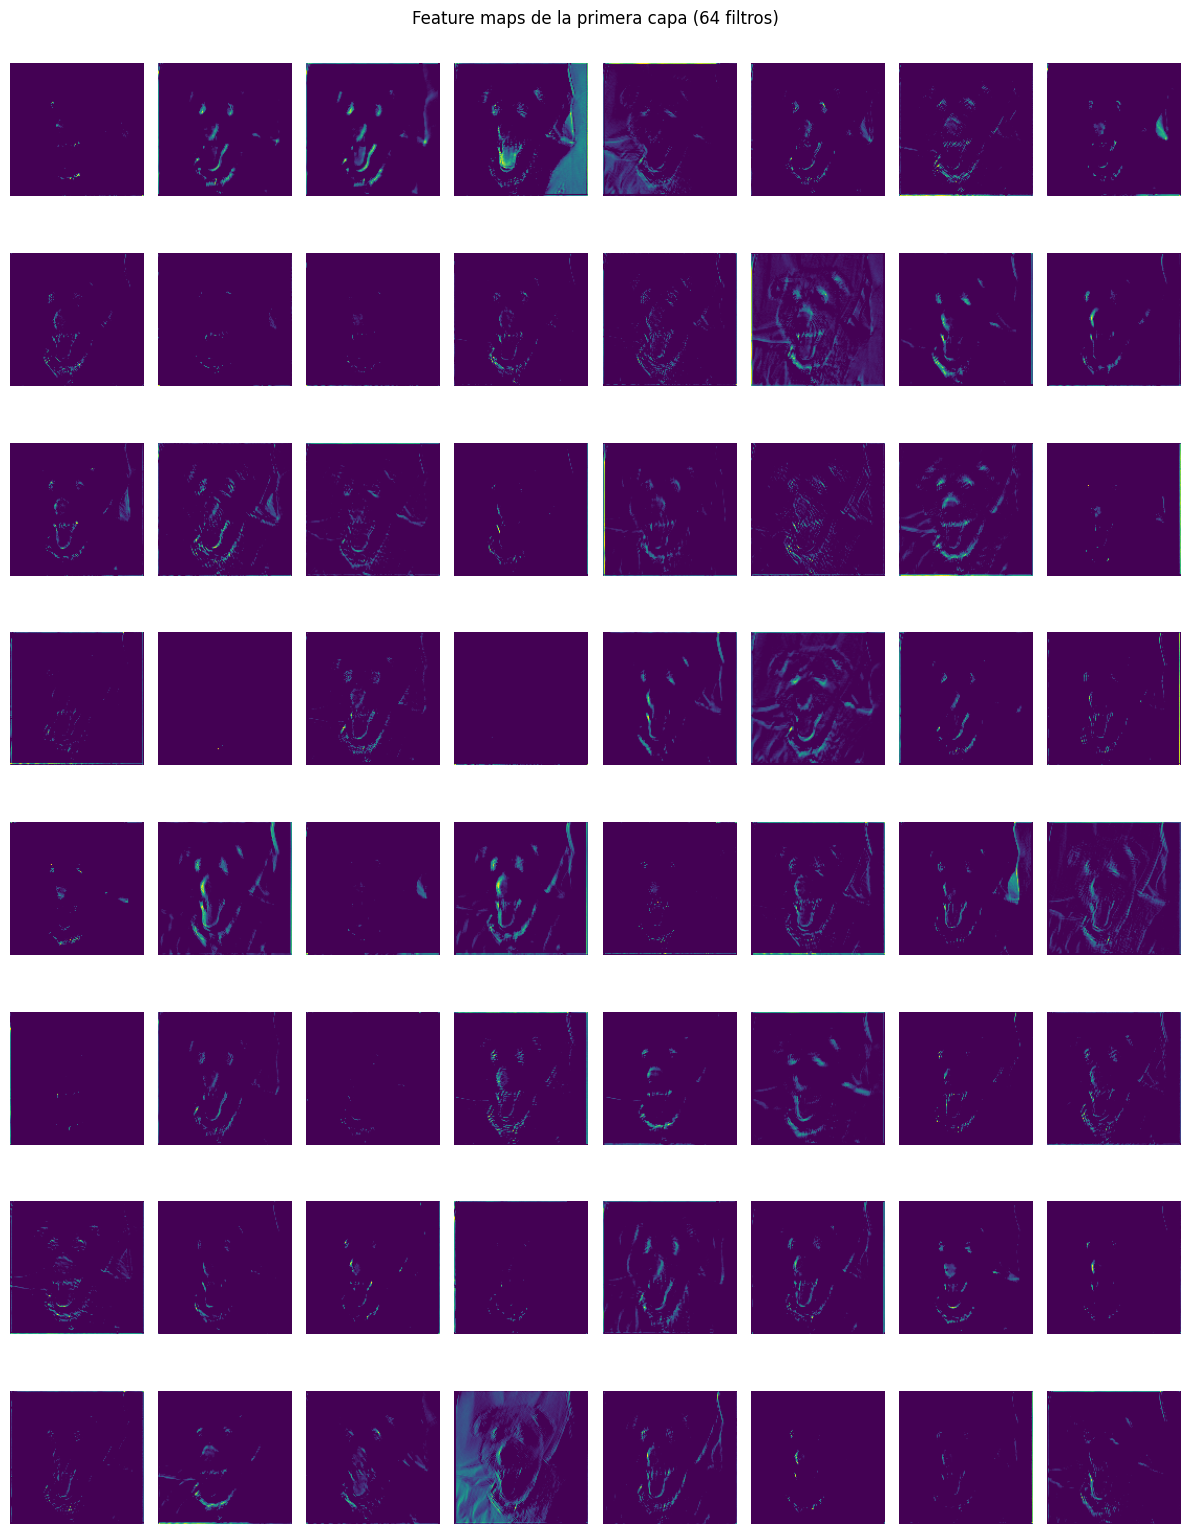

In [ ]:
# Plot de los feature maps
num_filters = feature_maps.shape[-1] # Get the number of filters dynamically
rows = num_filters // 8 # Calculate rows for plotting
cols = 8 # Set columns for plotting

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2)) # Adjust figure size based on rows
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# Flatten the axes array for easy iteration
axes = axes.ravel()

for i in range(num_filters): # Iterate over all filters
    ax = axes[i]
    ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
    ax.axis('off')

plt.suptitle(f"Feature maps de la primera capa ({num_filters} filtros)") # Update title
plt.tight_layout()
plt.show()

# Conclusión

El modelo elegido a través del optimizador presentó un accuracy en validation aceptable, mostrando progresión en comparación con otros modelos probados.

Sin embargo, queremos hacer una mención especial al modelo 4 sin optimizar que siendo un modelo probado por mera intuición logró más de 80% en validation y alcanzó 81,7% en test, algo que ni siquiera logró el modelo elegido por nosotros.

Obviamente elegimos nuestro modelo porque nos guiamos por el accuracy de validation, hacerlo por el de test no sería justo, pero remarcamos ese caso porque pueden ser indicios de un modelo flexible y bien planteado.

En cuanto a nuestro modelo final, logró predecir bien algunas de las imágenes que le proporcionamos con mascotas de miembros del grupo, considerando además que no eran imágenes de 128x128 sino que hubo que redimensionarlas, pudiendo generar distorsiones.

Por último, en los feature maps es posible ver algunos filtros que muestran la interpetabilidad y las formas que identifican a un perro.